## Step 1: Put all libraries and packages at top

### Standard imports

In [1]:
# files and system
import os
import sys

In [2]:
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
# working with images
import cv2
import imageio
import scipy.ndimage
import skimage.transform

import torchvision.transforms as transforms

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import torchsummary
from tqdm import notebook

### Custom imports

In [5]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

sys.path.insert(0, './notebooks')

In [6]:
sys.path.insert(0, '../models')

# models
from unet import UNet
from unet_attention import UNet_attention

sys.path.insert(0, '../notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [7]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Evaluate validation performance (quantitative, full sized images)

### Load model

In [9]:
%ls ../checkpoints

ckpt_UNet_BCELoss_baseline.pth     ckpt_UNet_IoULoss_baseline.pth
ckpt_UNet_IoUBCELoss_baseline.pth  ckpt_UNet_IoULoss_baseline_submitted.pth
ckpt_UNet_IoULoss_attention.pth    README.md
ckpt_UNet_IoULoss_augmented.pth


In [154]:
# model_name = 'UNet_IoULoss_baseline'
# model_name = 'UNet_BCELoss_baseline'
# model_name = 'UNet_IoUBCELoss_baseline'
# model_name = 'UNet_IoULoss_augmented'
# model_name = 'UNet_IoULoss_attention'


# submitted
model_name = 'UNet_IoULoss_baseline_submitted'


# instansiate the model
if model_name == 'UNet_IoULoss_attention':
    model = UNet_attention(channel_in=3, channel_out=1)
else:
    model = UNet(channel_in=3, channel_out=1)

 # load model to DEVICE
model = model.to(DEVICE)

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

<All keys matched successfully>

### Print info and Plot learning curves:

In [155]:
history = torch.load(f'../checkpoints/ckpt_{model_name}.pth')

best_epoch = history['epoch']
best_iou = history['iou'].item()

print('Best epoch:', best_epoch)
print(f'Validation IoU:', best_iou)

Best epoch: 47
Validation IoU: 0.7007678747177124


In [157]:
# train_losses = history['train_losses']
# val_losses = history['val_losses']

# # plot
# plt.figure(figsize=(18, 9))
# plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
# plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid', linewidth=3)
# plt.axvline(x=best_epoch, label='Best epoch', color='red')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f'Best epoch: {best_epoch}. Best Validation IoU: {best_iou:.4}')
# plt.legend(loc='best')
# plt.show()

### Produce predictions on Validation Set

In [158]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"

with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]
    
_size = 256, 256
resize = transforms.Resize(_size, interpolation=0)

In [159]:
%mkdir ../predictions_val

mkdir: cannot create directory ‘../predictions_val’: File exists


In [160]:
PRED_PATH = '../predictions_val'
time_taken = []
ious = []
metrics = {}

model.eval() # enter inference/evaluation mode 
for name in notebook.tqdm(ids_val):
    metrics[name] = {} # to record metrics for this particular image
    path_img = os.path.join(path_images, name)
    path_mask = os.path.join(path_masks, name)
    
    img = imageio.imread(path_img) / 255
    mask = imageio.imread(path_mask)[:, :, 0] / 255
    mask = mask.round() # binarize to 0 or 1 
    
    # record shape to revert to 
    H, W, _ = img.shape
    resize_back = transforms.Resize((H, W), interpolation=0)
    
    # convert to Tensors and fix the dimentions (Pytorch uses the channels in the first dimension)
    img = torch.FloatTensor(np.transpose(img, [2, 0 ,1])).unsqueeze(0) 
    mask_binary = torch.FloatTensor(mask).unsqueeze(0)
    
    # resize for the model
    img, mask = resize(img), resize(mask_binary)
    
    # put on the GPU
    img, mask = img.to(DEVICE), mask.to(DEVICE)
    
    # we do not need to calculate gradients
    with torch.no_grad():
        # Start time
        start_time = time.time()
        ## Prediction
        pred = model(img)
        # End timer
        end_time = time.time() - start_time

    time_taken.append(end_time)
    #print("{} - {:.10f}".format(name, end_time))
        
    
    # resize back, nearest interpolation, since it's a mask
    pred = resize_back(pred)
    # put on cpu
    pred = pred.cpu()
    # remove channel => BATCH x H x W
    pred = pred.squeeze(0)
    
    
    # sigmoid, threshold, record score
    ious.append(iou_pytorch_test(pred, mask_binary).item())
        
    metrics[name]['Jaccard'] = iou_pytorch_test(pred, mask_binary).item()
    metrics[name]['DSC'] = dice_pytorch_test(pred, mask_binary).item()
    metrics[name]['Recall'] = recall_pytorch_test(pred, mask_binary).item()
    metrics[name]['Precision'] = precision_pytorch_test(pred, mask_binary).item()
    metrics[name]['F2'] = fbeta_pytorch_test(pred, mask_binary, beta=2.).item()
    metrics[name]['Accuracy'] = accuracy_pytorch_test(pred, mask_binary, ).item()
    
    # comment out if your model contains a sigmoid or equivalent activation layer
    pred = torch.sigmoid(pred)
    # thresholding since that's how we will make predictions on new imputs
    pred = pred > 0.5 
    # remove BATCH => H x W
    pred = pred.squeeze(0)
    # converto to correct type
    pred = pred.numpy().astype(np.float32)
    # revert to standard intensities
    pred = pred * 255.0
    # save
    pred_path = os.path.join(PRED_PATH, name)
    cv2.imwrite(pred_path, pred)


mean_time_taken = np.mean(time_taken)
mean_fps = 1/mean_time_taken
print("\nmean time taken: ", mean_time_taken)
print("Mean FPS: ", mean_fps)

mean_iou = np.mean(ious)
print("\nMean IoU: ", mean_iou)



mean time taken:  0.004123717546463013
Mean FPS:  242.49963503385874

Mean IoU:  0.6927659712111248


In [161]:
metrics_df = pd.DataFrame(metrics).T.round(5)
metrics_df = metrics_df[['Jaccard', 'DSC', 'Recall', 'Precision', 'Accuracy', 'F2']]
metrics_df = metrics_df.sort_values('Jaccard', ascending=False)
#metrics_df

### Mean Scores

In [162]:
metrics_df.mean(axis=0)

Jaccard      0.692766
DSC          0.782144
Recall       0.868579
Precision    0.789453
Accuracy     0.939065
F2           0.802554
dtype: float64

In [163]:
# for LaTeX table
' & '.join(list(metrics_df.mean(axis=0).round(4).values.astype(str)))

'0.6928 & 0.7821 & 0.8686 & 0.7895 & 0.9391 & 0.8026'

## Step 5: Evaluate validation performance (visial, full sized images)

### Best cases

In [82]:
list(metrics_df.head().index)

['cju16ach3m1da0993r1dq3sn2.jpg',
 'cju8cj10qsrau0871o2dr6ai1.jpg',
 'cju13cgqmnhwn0988yrainhcp.jpg',
 'cju85omszllp30850b6rm9mi3.jpg',
 'cju7dp3dw2k4n0755zhe003ad.jpg']

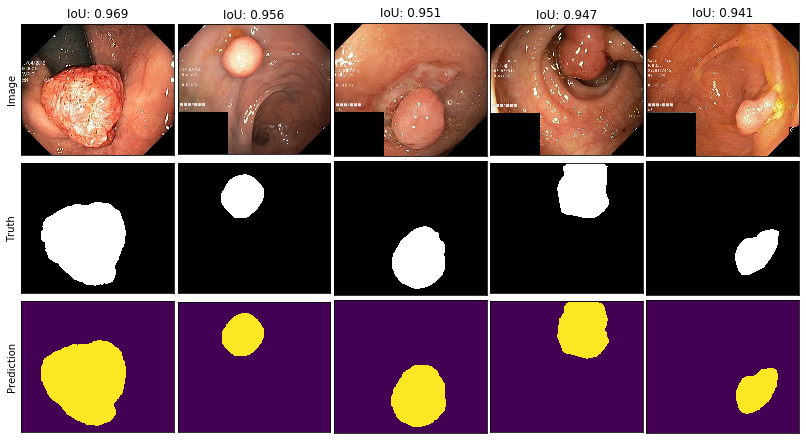

In [83]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.head().index):
    
    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')
    
    plt.subplot(3,5,i+6)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3,5,i+11)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')
    
    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
plt.show()

### Worst cases

In [164]:
list(metrics_df.tail().index)

['cju884985nlmx0817vzpax3y4.jpg',
 'cju87li0zn3yb0817kbwgjiz8.jpg',
 'cju16whaj0e7n0855q7b6cjkm.jpg',
 'cju13hp5rnbjx0835bf0jowgx.jpg',
 'cju0tl3uz8blh0993wxvn7ly3.jpg']

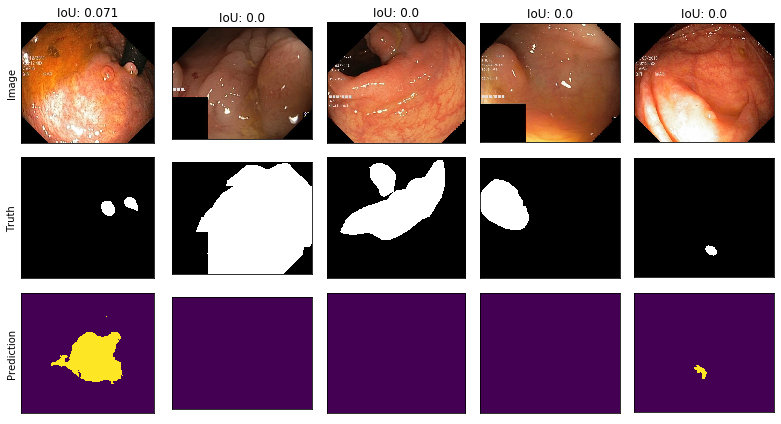

In [165]:
#plt.figure(figsize=(15, 5))
plt.subplots(3, 5, sharex=True, sharey=True, figsize=(11, 6))

for i, name in enumerate(metrics_df.tail().index):
    
    plt.subplot(3,5,i+1)
    plt.title(f"IoU: {metrics_df.loc[name]['Jaccard'].round(3)}")
    img = imageio.imread(f'../data/train-val/images/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')
    
    plt.subplot(3,5,i+6)
    mask = imageio.imread(f'../data/train-val/masks/{name}')
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Truth')
    
    plt.subplot(3,5,i+11)
    pred = imageio.imread(f'../predictions_val/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')
    
    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')


plt.tight_layout()
plt.show()